# Image Captioning using VGG16 and LSTM

## Setting up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/dl_assignments/dl_project/Flickr8k.zip" -d "/content/dl_project"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dl_project/Flickr8k/Flicker8k_Dataset/2844846111_8c1cbfc75d.jpg  
  inflating: /content/dl_project/__MACOSX/Flickr8k/Flicker8k_Dataset/._2844846111_8c1cbfc75d.jpg  
  inflating: /content/dl_project/Flickr8k/Flicker8k_Dataset/1082252566_8c79beef93.jpg  
  inflating: /content/dl_project/__MACOSX/Flickr8k/Flicker8k_Dataset/._1082252566_8c79beef93.jpg  
  inflating: /content/dl_project/Flickr8k/Flicker8k_Dataset/1386251841_5f384a0fea.jpg  
  inflating: /content/dl_project/__MACOSX/Flickr8k/Flicker8k_Dataset/._1386251841_5f384a0fea.jpg  
  inflating: /content/dl_project/Flickr8k/Flicker8k_Dataset/2196316998_3b2d63f01f.jpg  
  inflating: /content/dl_project/__MACOSX/Flickr8k/Flicker8k_Dataset/._2196316998_3b2d63f01f.jpg  
  inflating: /content/dl_project/Flickr8k/Flicker8k_Dataset/3106791484_13e18c33d8.jpg  
  inflating: /content/dl_project/__MACOSX/Flickr8k/Flicker8k_Dataset/._3106791484_13e18c33d8.jpg  
  inflating: /

In [ ]:
import os
import time
import progressbar
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import sys
import warnings
import numpy as np
import pandas as pd
from collections import Counter
from keras.preprocessing.image import load_img
from nltk.tokenize import word_tokenize
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
from PIL import Image
import string
import re

from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

In [ ]:
warnings.filterwarnings("ignore")

# Configure TensorFlow session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

## Caption Preprocessing

In [ ]:
image_caption_folder_path = "/content/dl_project/Flickr8k/Flickr8k.token.txt"

image_folder_path = "/content/dl_project/Flickr8k/Flicker8k_Dataset"

jpgs = os.listdir(image_folder_path)
print("The number of jpg flies in Flicker 8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker 8k: 8091


Extracting captions from caption text file

In [ ]:
#Finding the captions for each image.
file = open(image_caption_folder_path,'r', encoding='utf8')
caption_file = file.read()
file.close()


datatxt = []
for line in caption_file.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    image_id, image_index = col[0].split("#")
    image_caption = col[1].lower()
    datatxt.append([image_id, image_index, image_caption])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])

unique_filenames = np.unique(df_txt.filename.values)
print("The number of unique file ids : {}".format(len(unique_filenames)))
df_txt.head(10)

The number of unique file ids : 8092


filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   
5  1001773457_577c3a7d70.jpg     0   
6  1001773457_577c3a7d70.jpg     1   
7  1001773457_577c3a7d70.jpg     2   
8  1001773457_577c3a7d70.jpg     3   
9  1001773457_577c3a7d70.jpg     4   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  
5         a black dog and a spotted dog are fighting  
6  a black dog and a tri-colored dog playing with...  
7  a black dog and a white dog with brown spots a...  
8  two dogs of different breeds looking at each o...  
9    two dogs on pavement moving toward each other .

Displaying sample images and their actual captions

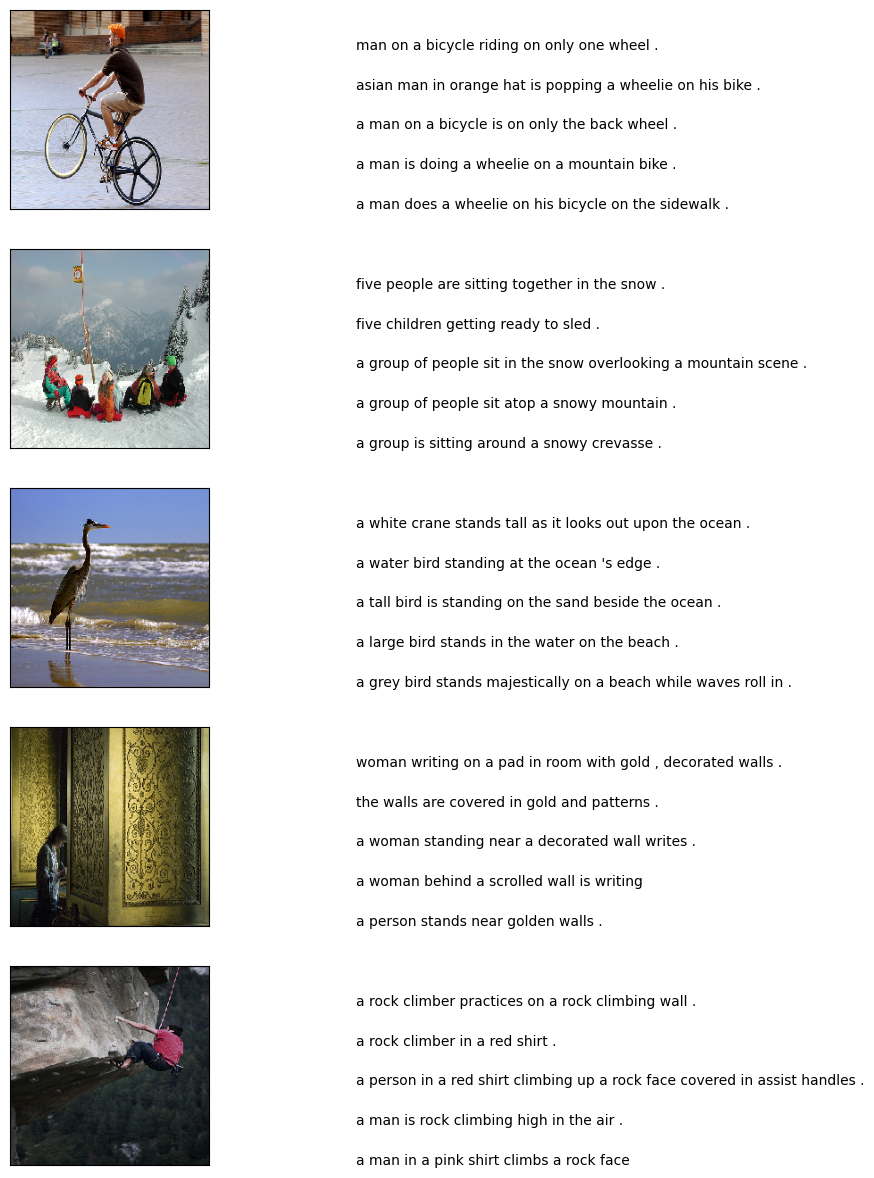

In [ ]:
npic = 5 # Displaying 5 images from the dataset
target_size = (224, 224, 3)
count = 1
fig = plt.figure(figsize=(10,15))

for image_id in unique_filenames[-5:]:
    filename = image_folder_path + '/' + image_id
    captions = list(df_txt["caption"].loc[df_txt["filename"] == image_id].values)
    image_load = load_img(filename, target_size=target_size)

    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=10)
    count += 1
plt.show()

### Cleaning captions

In [ ]:
# Counts the occurance of all words in captions
def df_word(df_txt):
    vocabulary = []
    for i in range(len(df_txt)):
        temp=df_txt.iloc[i,2]
        vocabulary.extend(temp.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

Before Preprocessing: 50 most frequently and 50 least frequently appearing words

Vocabulary Size: 8918


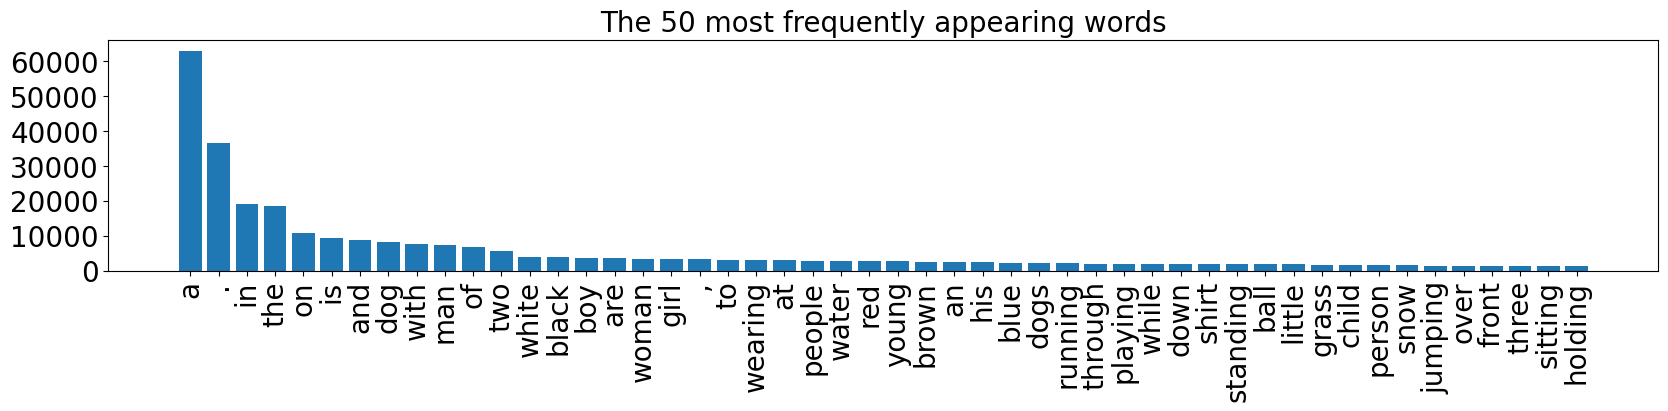

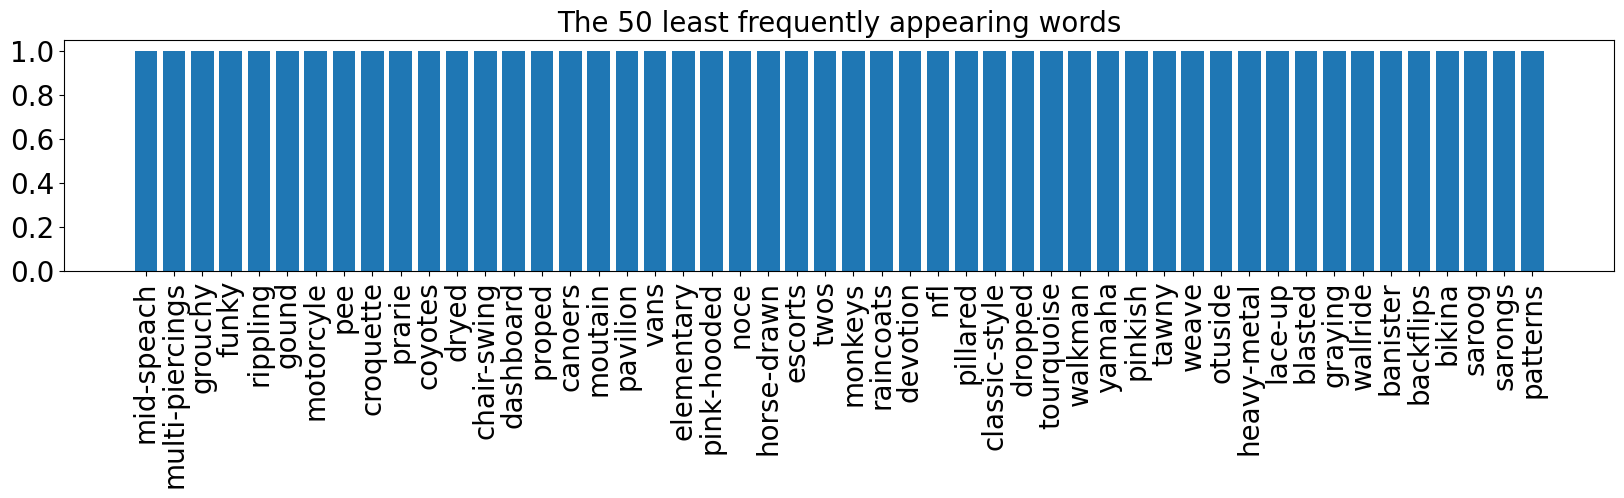

In [ ]:
topn = 50
def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The 50 most frequently appearing words")

plthist(dfword.iloc[-topn:,:],
        title="The 50 least frequently appearing words")

In [ ]:
def remove_punctuation(text_original):
    return text_original.translate(str.maketrans('','',string.punctuation))

def remove_single_character(text):
    words = text.split()

    filtered_words = [word for word in words if len(word) > 1]

    new_sentence = ' '.join(filtered_words)
    return new_sentence

def remove_numeric(text):
    return re.sub(r'\d+', '', text)

def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return text

with progressbar.ProgressBar(max_value=len(df_txt.caption.values)) as bar:
    for i, caption in enumerate(df_txt.caption.values):
        newcaption = text_clean(caption)
        df_txt["caption"].iloc[i] = newcaption
        bar.update(i)


100% (40460 of 40460) |##################| Elapsed Time: 0:00:15 Time:  0:00:15


After Preprocessing: 50 most frequently and 50 least frequently appearing words

Vocabulary Size: 8768


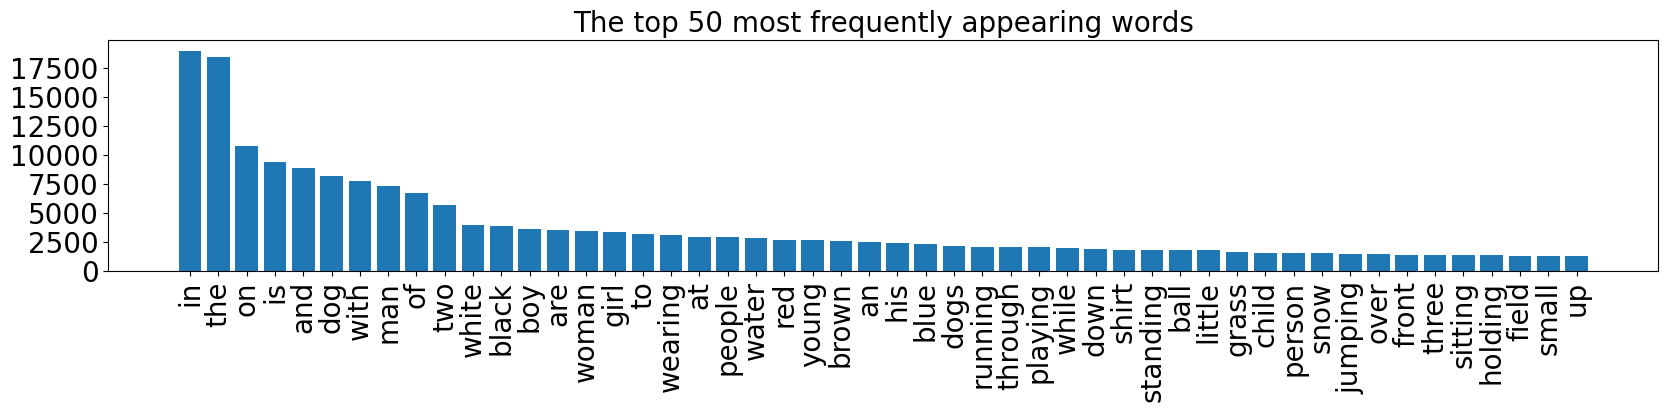

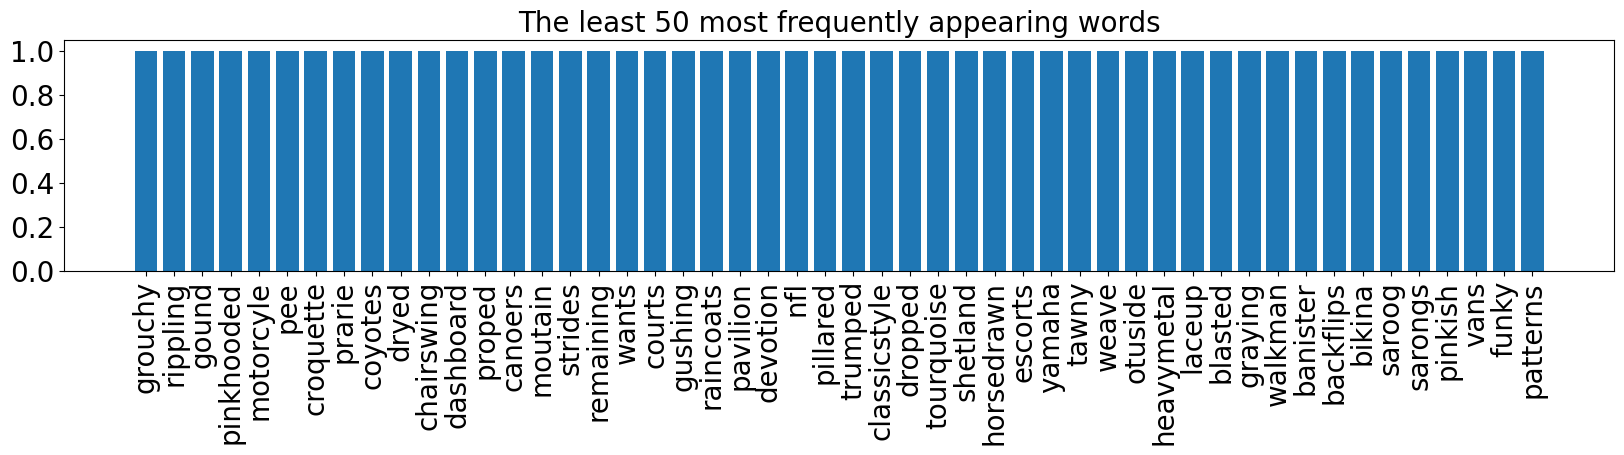

In [ ]:
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [ ]:
#adding start and end sequence
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
# df_txt0.head(5)
# del df_txt
df_txt0.head()

filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  startseq child in pink dress is climbing up se...  
1    startseq girl going into wooden building endseq  
2  startseq little girl climbing into wooden play...  
3  startseq little girl climbing the stairs to he...  
4  startseq little girl in pink dress going into ...

## VGG 16

In [ ]:
# Loading VGG16 model and weights to extract features from the images
from keras.applications import VGG16

modelvgg = VGG16(include_top=True,weights=None)
## load the locally saved weights
modelvgg.load_weights("/content/drive/MyDrive/dl_assignments/dl_project/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras import models
# Deleting the last layer of the model
# The last layer of the VGG-16 is excluded here because we are are just using it for extracting the features rather than using for object classification.
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)
## show the deep learning model
modelvgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Feature extraction
# Here the features are extracted from all the images in the dataset. VGG-16 model gives out 4096 features from the input image of size 224 * 224

images = OrderedDict()
npix = 224 #image size is fixed at 224 because VGG16 model has been pre-trained to take that size.
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))

for i, image_id in enumerate(jpgs):
    # load an image from file
    filename = image_folder_path + '/' + image_id
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)

    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[image_id] = y_pred.flatten()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step


## LSTM Data preprocessing

In [ ]:
# Merging the images and the captions for training
dimages, keepindex = [],[]
# Creating a datframe where only first caption is taken for processing
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)

#fnames are the names of the image files
fnames = df_txt0["filename"].iloc[keepindex].values
#dcaptions are the captions of the images
dcaptions = df_txt0["caption"].iloc[keepindex].values
#dimages are the actual features of the images
dimages = np.array(dimages)
df_txt0[:5]

filename index  \
0   1000268201_693b08cb0e.jpg     0   
5   1001773457_577c3a7d70.jpg     0   
10  1002674143_1b742ab4b8.jpg     0   
15  1003163366_44323f5815.jpg     0   
20  1007129816_e794419615.jpg     0   

                                              caption  
0   startseq child in pink dress is climbing up se...  
5   startseq black dog and spotted dog are fightin...  
10  startseq little girl covered in paint sits in ...  
15  startseq man lays on bench while his dog sits ...  
20  startseq man in an orange hat starring at some...

In [ ]:
# Tokenizing the captions for further processing
# As the model can't take texts as an input, they need to converted into vectors.

from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 6000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 4478
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


In [ ]:
# Splitting the training and test data
prop_test, prop_val = 0.2, 0.2

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest],
           dtexts[Ntest:Ntest+Nval],
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)
# Finding the max length of the caption
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

30


In [ ]:
# Processing the captions and images as per the required shape by the model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages)) # using assert to make sure that length of images and captions are always similar
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        # zip() is used to create a tuple of iteratable items
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()# using pad sequence to make the length of all captions equal
            out_text = to_categorical(out_text,num_classes = vocab_size) # using to_categorical to


            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 4855
 (49633, 30) (49633, 4096) (49633, 4478)
# captions/images = 1618
 (16353, 30) (16353, 4096) (16353, 4478)


## LSTM model building

In [ ]:
# Building the LSTM model
from keras import layers
from keras.models import Model

print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256, activation='relu', name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size, dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256, name="CaptionFeature", return_sequences=True)(ftxt)
se2 = layers.Dropout(0.04)(ftxt)
ftxt = layers.LSTM(256, name="CaptionFeature2")(se2)
## combined model for decoder
decoder = layers.add([ftxt, fimage])
decoder = layers.Dense(256, activation='relu')(decoder)
output = layers.Dense(vocab_size, activation='softmax')(decoder)
model = Model(inputs=[input_image, input_txt], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


4478
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 64)               286592    ['input_4[0][0]']             
                                                                                                  
 CaptionFeature (LSTM)       (None, 30, 256)              328704    ['embedding[0][0]']           
                                                                                                  
 dropout (Dropout)           (None, 30, 256)              0         ['CaptionFeature[0][0]']      
                                                                                       

Epoch 1/6
1552/1552 - 250s - loss: 5.3327 - accuracy: 0.1625 - val_loss: 4.8065 - val_accuracy: 0.2164 - 250s/epoch - 161ms/step
Epoch 2/6
1552/1552 - 226s - loss: 4.4275 - accuracy: 0.2289 - val_loss: 4.5616 - val_accuracy: 0.2503 - 226s/epoch - 146ms/step
Epoch 3/6
1552/1552 - 224s - loss: 4.0150 - accuracy: 0.2625 - val_loss: 4.4657 - val_accuracy: 0.2695 - 224s/epoch - 145ms/step
Epoch 4/6
1552/1552 - 228s - loss: 3.7483 - accuracy: 0.2817 - val_loss: 4.4971 - val_accuracy: 0.2744 - 228s/epoch - 147ms/step
Epoch 5/6
1552/1552 - 226s - loss: 3.5321 - accuracy: 0.2938 - val_loss: 4.5708 - val_accuracy: 0.2821 - 226s/epoch - 146ms/step
Epoch 6/6
1552/1552 - 224s - loss: 3.3579 - accuracy: 0.3057 - val_loss: 4.7230 - val_accuracy: 0.2771 - 224s/epoch - 144ms/step


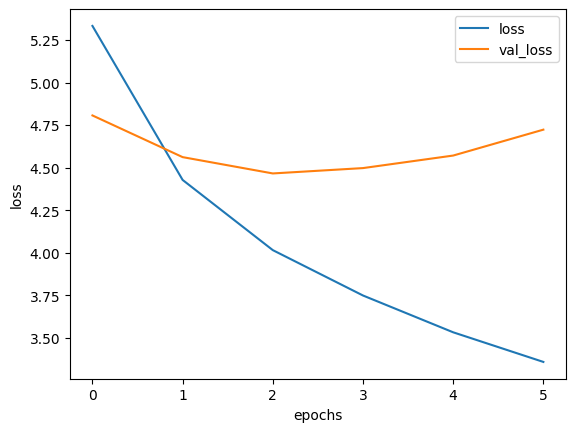

In [ ]:
# Training the LSTM model
# fit model
from time import time
from keras.callbacks import TensorBoard
from keras.models import load_model

model_file = 'trained_lstm_model.keras'
if os.path.exists(model_file):
  model = load_model(model_file)
else:
  tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
  #start = time.time()
  hist = model.fit([Ximage_train, Xtext_train], ytext_train,
                  epochs=6, verbose=2,
                  batch_size=32,
                  validation_data=([Ximage_val, Xtext_val], ytext_val),callbacks=[tensorboard])
  #end = time.time()
  #print("TIME TOOK {:3.2f}MIN".format((end - start )/60))


  for label in ["loss","val_loss"]:
      plt.plot(hist.history[label],label=label)
  plt.legend()
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.show()

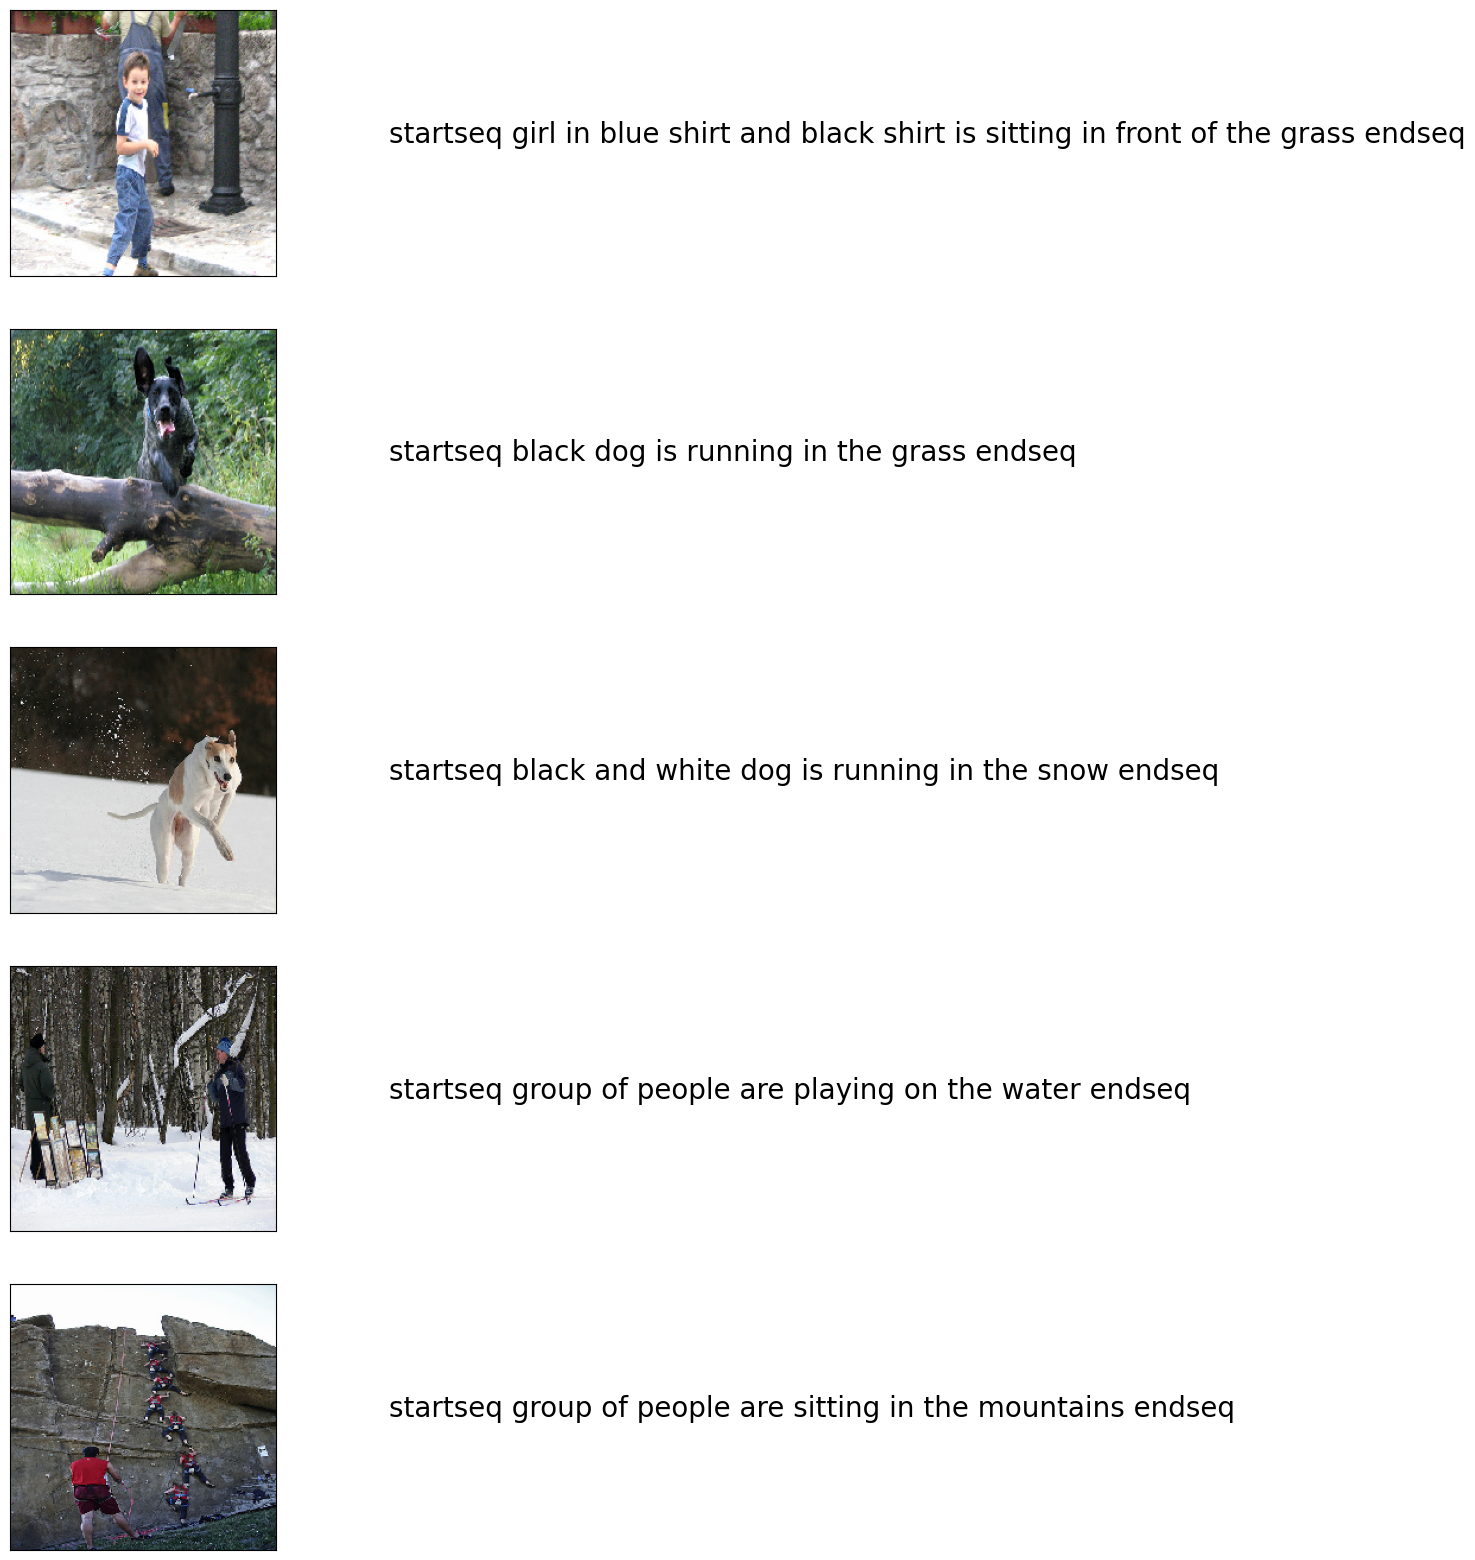

In [ ]:
# Generating captions on a small set of images
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[8:13],di_test[8:13]):
    ## images
    filename = image_folder_path + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [ ]:
# Evaluating the model performance
# Generating captions for the whole test data and finding BLEU score
from nltk.translate.bleu_score import sentence_bleu

index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], []
count = 0
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))

    caption_true = [ index_word[i] for i in tokenized_text ]
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg

    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..
Mean BLEU 0.011


In [ ]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images
        filename = image_folder_path + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)

        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

Bad Caption


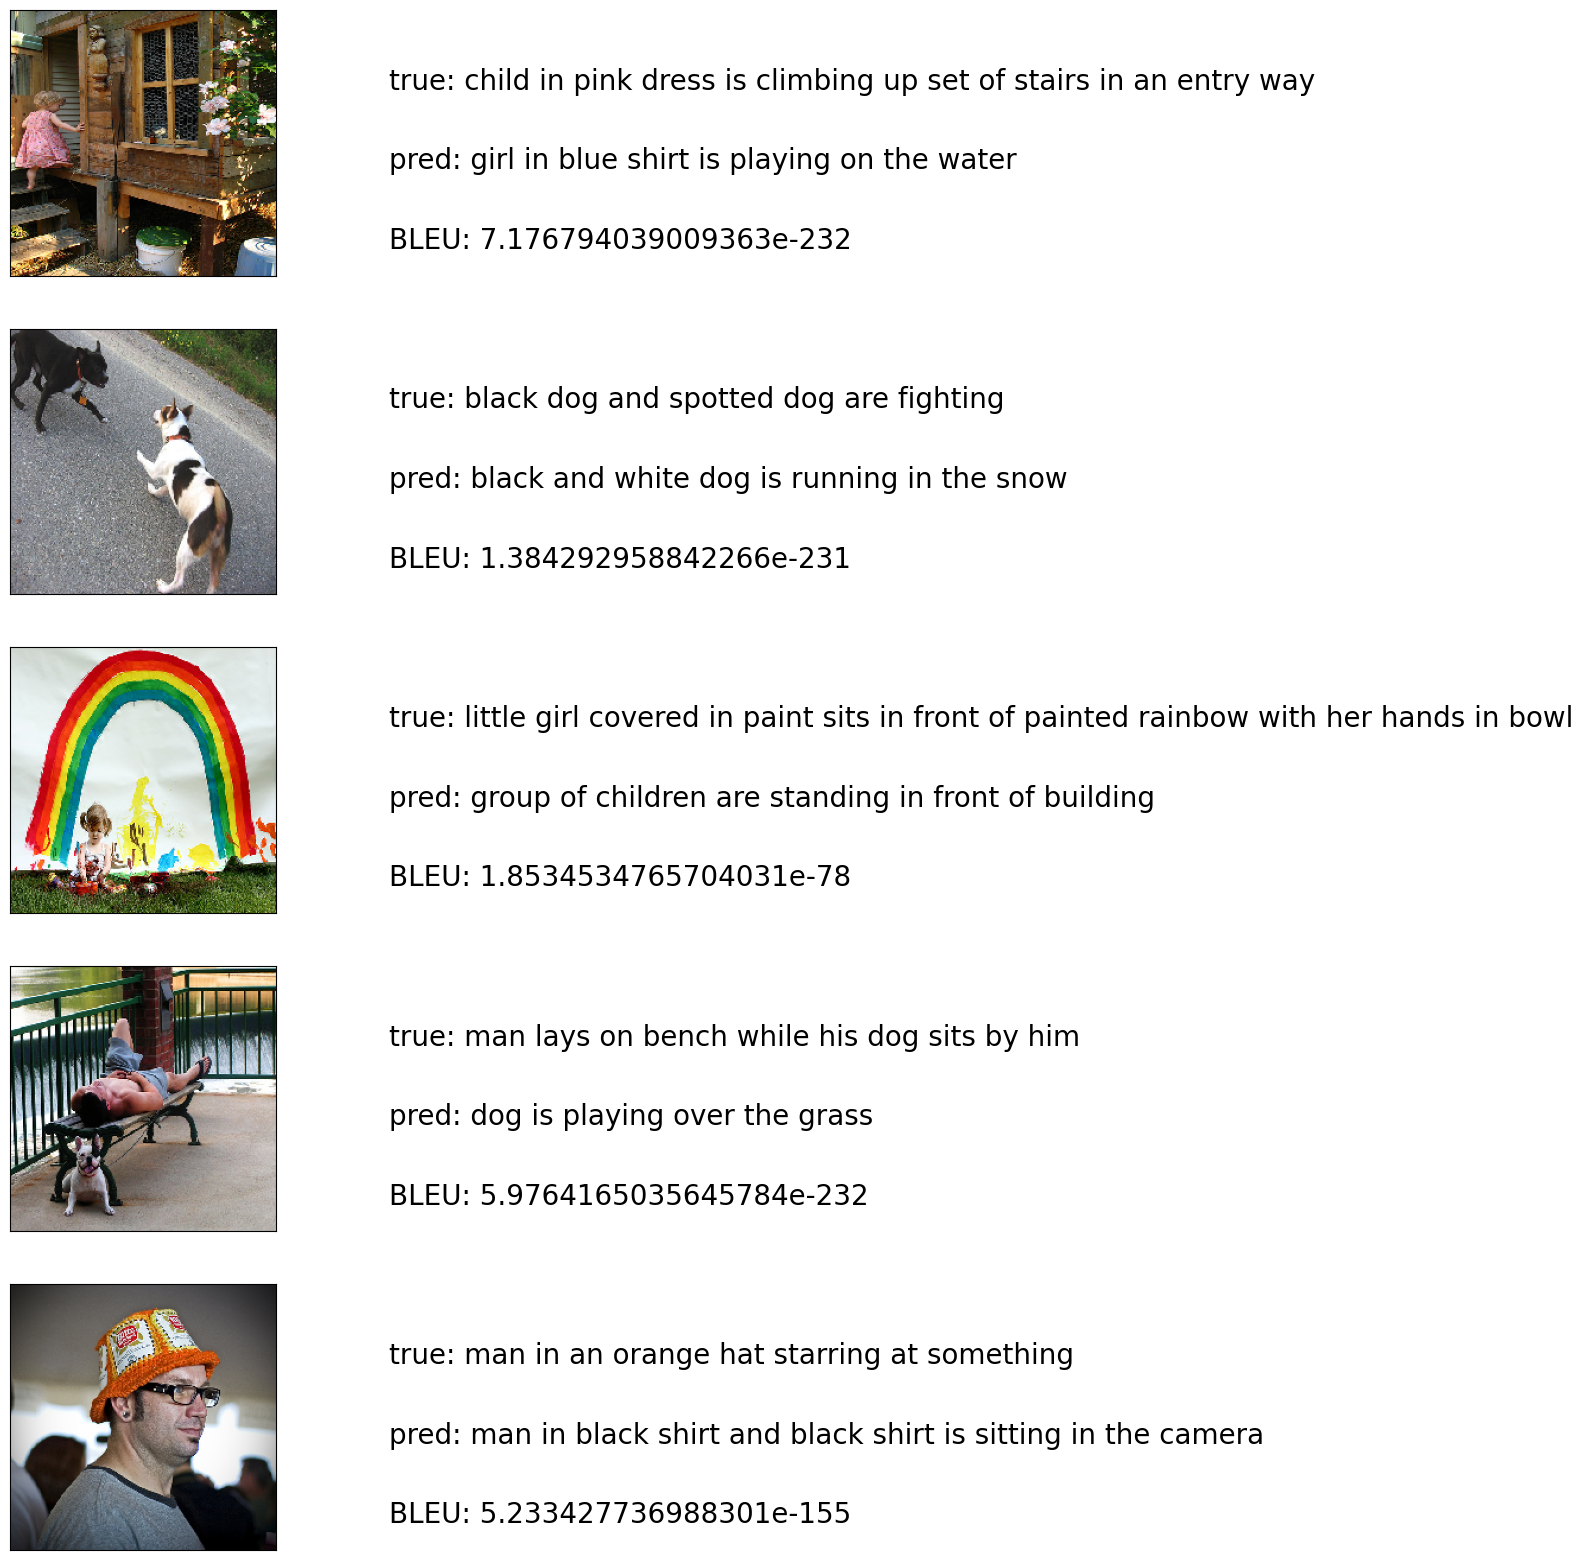

Good Caption


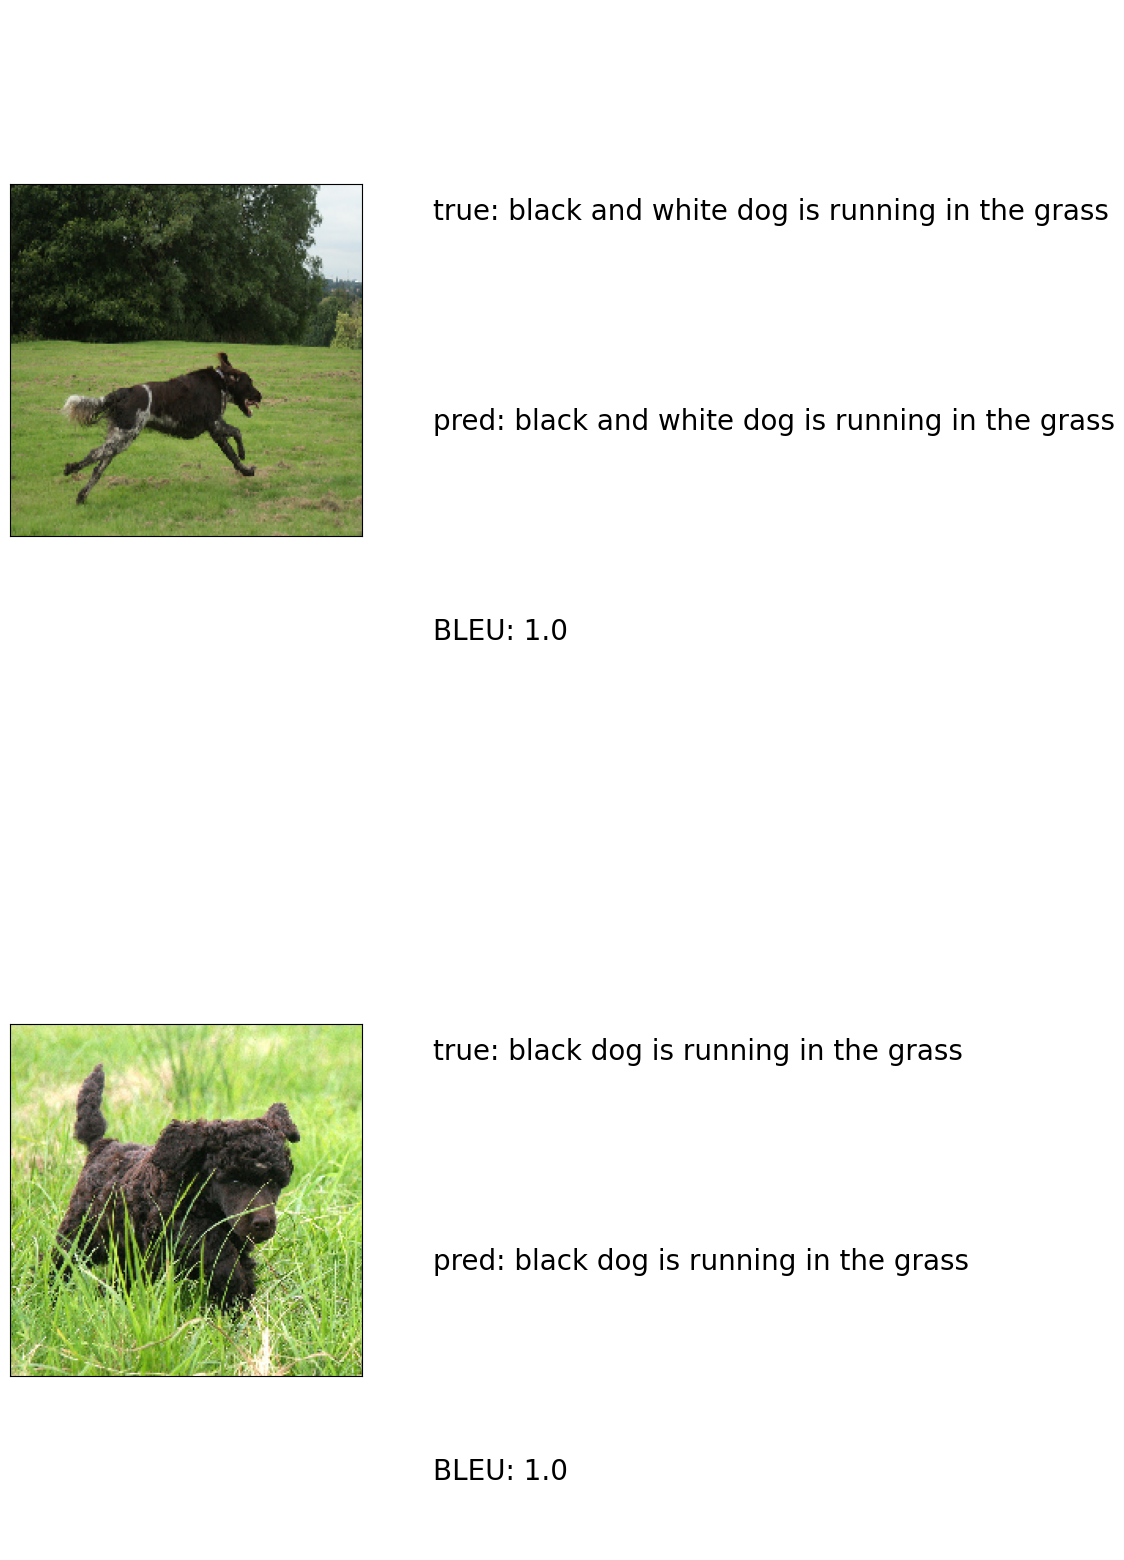

In [ ]:
print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)